

* 110269
* 113501
* 114199
* 105026


In [149]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
import matplotlib.pyplot as plt
import matplotlib
import tensorflow as tf
from tensorflow.keras.layers import InputLayer,Dense
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split

#Import the dataset

In [150]:
data=pd.read_csv('/content/drive/MyDrive/Housing Pricing.csv')

In [151]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [152]:
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,0,12,2008,WD,Normal,250000


#Prepare the dataset

Search for missing values and filling

In [153]:
data.drop('Id',axis=1,inplace=True)

In [154]:
data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,0,12,2008,WD,Normal,250000


In [155]:
data.shape

(1460, 76)

In [156]:
data.isna().any()

MSSubClass       False
MSZoning         False
LotFrontage       True
LotArea          False
Street           False
                 ...  
MoSold           False
YrSold           False
SaleType         False
SaleCondition    False
SalePrice        False
Length: 76, dtype: bool

In [157]:
original_features=list(data.columns)
original_features
len(original_features)

76

In [158]:
features_with_missing=list(data.columns[data.isna().any()])
features_with_missing
len(features_with_missing)

15

In [159]:
for feature in features_with_missing:
  print(feature,'',data[feature].isna().sum()/len(data)*100)

LotFrontage  17.73972602739726
MasVnrType  0.547945205479452
MasVnrArea  0.547945205479452
BsmtQual  2.5342465753424657
BsmtCond  2.5342465753424657
BsmtExposure  2.6027397260273974
BsmtFinType1  2.5342465753424657
BsmtFinType2  2.6027397260273974
Electrical  0.0684931506849315
FireplaceQu  47.26027397260274
GarageType  5.5479452054794525
GarageYrBlt  5.5479452054794525
GarageFinish  5.5479452054794525
GarageQual  5.5479452054794525
GarageCond  5.5479452054794525


In [160]:
data.dropna(axis=1,thresh=0.5*len(data),inplace=True)

Filling using mean fill,bfill and ffill

In [161]:
mean_fill=['LotFrontage','MasVnrArea']
bfill=['FireplaceQu']
ffill=list(set(features_with_missing)-set(mean_fill)-set(bfill))
ffill

['BsmtFinType1',
 'BsmtCond',
 'Electrical',
 'GarageQual',
 'GarageCond',
 'BsmtExposure',
 'GarageYrBlt',
 'MasVnrType',
 'BsmtQual',
 'GarageType',
 'BsmtFinType2',
 'GarageFinish']

In [162]:
for feature in mean_fill:
  data[feature].fillna(data[feature].mean(),inplace=True)

In [163]:
for feature in ffill:
  data[feature].fillna(method='ffill',inplace=True)

In [164]:
for feature in bfill:
  data[feature].fillna(method='bfill',inplace=True)

In [165]:
data.isna().any()

MSSubClass       False
MSZoning         False
LotFrontage      False
LotArea          False
Street           False
                 ...  
MoSold           False
YrSold           False
SaleType         False
SaleCondition    False
SalePrice        False
Length: 76, dtype: bool

# Encoding dataset

In [166]:
cat_data=data.select_dtypes(include=['object']).copy()
cat_data.head(2)

,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
0,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,WD,Normal
1,RL,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,Gable,CompShg,MetalSd,MetalSd,None,TA,TA,CBlock,Gd,TA,Gd,ALQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,TA,Attchd,RFn,TA,TA,Y,WD,Normal


In [167]:
cat_features=list(cat_data.columns)
cat_features

['MSZoning',
 'Street',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'SaleType',
 'SaleCondition']

In [168]:
nominal=['MSZoning','LandContour','LotConfig','Neighborhood']
ordinal=list(set(cat_features)-set(nominal))
numerical=list(set(original_features)-set(cat_features))
target=['SalePrice']

In [169]:
data[numerical]

,LotArea,YearBuilt,MSSubClass,TotRmsAbvGrd,GarageYrBlt,YearRemodAdd,BedroomAbvGr,LotFrontage,BsmtFinSF2,FullBath,Fireplaces,OverallQual,KitchenAbvGr,LowQualFinSF,2ndFlrSF,WoodDeckSF,1stFlrSF,BsmtHalfBath,BsmtUnfSF,BsmtFullBath,GrLivArea,YrSold,OverallCond,MasVnrArea,GarageCars,BsmtFinSF1,ScreenPorch,3SsnPorch,PoolArea,MiscVal,SalePrice,HalfBath,EnclosedPorch,MoSold,GarageArea,OpenPorchSF,TotalBsmtSF
0,8450,2003,60,8,2003.0,2003,3,65.0,0,2,0,7,1,0,854,0,856,0,150,1,1710,2008,5,196.0,2,706,0,0,0,0,208500,1,0,2,548,61,856
1,9600,1976,20,6,1976.0,1976,3,80.0,0,2,1,6,1,0,0,298,1262,1,284,0,1262,2007,8,0.0,2,978,0,0,0,0,181500,0,0,5,460,0,1262
2,11250,2001,60,6,2001.0,2002,3,68.0,0,2,1,7,1,0,866,0,920,0,434,1,1786,2008,5,162.0,2,486,0,0,0,0,223500,1,0,9,608,42,920
3,9550,1915,70,7,1998.0,1970,3,60.0,0,1,1,7,1,0,756,0,961,0,540,1,1717,2006,5,0.0,3,216,0,0,0,0,140000,0,272,2,642,35,756
4,14260,2000,60,9,2000.0,2000,4,84.0,0,2,1,8,1,0,1053,192,1145,0,490,1,2198,2008,5,350.0,3,655,0,0,0,0,250000,1,0,12,836,84,1145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,7917,1999,60,7,1999.0,2000,3,62.0,0,2,1,6,1,0,694,0,953,0,953,0,1647,2007,5,0.0,2,0,0,0,0,0,175000,1,0,8,460,40,953
1456,13175,1978,20,7,1978.0,1988,3,85.0,163,2,2,6,1,0,0,349,2073,0,589,1,2073,2010,6,119.0,2,790,0,0,0,0,210000,0,0,2,500,0,1542
1457,9042,1941,70,9,1941.0,2006,4,66.0,0,2,2,7,1,0,1152,0,1188,0,877,0,2340,2010,9,0.0,1,275,0,0,0,2500,266500,0,0,5,252,60,1152
1458,9717,1950,20,5,1950.0,1996,2,68.0,1029,1,0,5,1,0,0,366,1078,0,0,1,1078,2010,6,0.0,1,49,0,0,0,0,142125,0,112,4,240,0,1078


Integer encoding for ordinals

In [170]:
for feature in ordinal:
  data[feature]=(data[feature].astype('category')).cat.codes

One Hot encoding for nominals

In [171]:
df_nominal=pd.get_dummies(data[nominal])

In [172]:
df_ordinal=data[ordinal]

In [173]:
df_numerical=data[numerical]

In [174]:
encoded_data=pd.concat([df_numerical,df_nominal,df_ordinal],axis=1)

In [175]:
encoded_data.shape

(1460, 111)

# Standardize data

In [176]:
X=encoded_data.drop('SalePrice', axis=1)

In [177]:
X_without_target=encoded_data.drop('SalePrice', axis=1)

In [178]:
y=data[target]
y

,SalePrice
0,208500
1,181500
2,223500
3,140000
4,250000
...,...
1455,175000
1456,210000
1457,266500
1458,142125


In [179]:
X=X.to_numpy()
X

array([[8.450e+03, 2.003e+03, 6.000e+01, ..., 1.000e+00, 1.000e+00,
        5.000e+00],
       [9.600e+03, 1.976e+03, 2.000e+01, ..., 2.000e+00, 1.000e+00,
        5.000e+00],
       [1.125e+04, 2.001e+03, 6.000e+01, ..., 1.000e+00, 1.000e+00,
        5.000e+00],
       ...,
       [9.042e+03, 1.941e+03, 7.000e+01, ..., 2.000e+00, 1.000e+00,
        5.000e+00],
       [9.717e+03, 1.950e+03, 2.000e+01, ..., 2.000e+00, 1.000e+00,
        4.000e+00],
       [9.937e+03, 1.965e+03, 2.000e+01, ..., 2.000e+00, 1.000e+00,
        3.000e+00]])

In [180]:
X.shape

(1460, 110)

In [181]:
y=y.to_numpy()
y

array([[208500],
       [181500],
       [223500],
       ...,
       [266500],
       [142125],
       [147500]])

In [182]:
y.shape

(1460, 1)

In [183]:
X_standardized=StandardScaler().fit_transform(X)
y=StandardScaler().fit_transform(y)

In [184]:
y

array([[ 0.34727322],
       [ 0.00728832],
       [ 0.53615372],
       ...,
       [ 1.07761115],
       [-0.48852299],
       [-0.42084081]])

# Feature Selection using L1 =>Dimensionality Reduction

Feature selection using LassoCV

In [185]:
lasso = LassoCV()
lasso.fit(X_standardized,y.ravel())

LassoCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
        max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
        positive=False, precompute='auto', random_state=None,
        selection='cyclic', tol=0.0001, verbose=False)

In [186]:
print(lasso.coef_)

[ 4.61672044e-02  5.16138236e-02 -6.58953080e-02  4.62805556e-02
  0.00000000e+00  1.42918126e-02 -9.87233181e-03 -2.40709126e-02
  6.94389882e-03  3.24586435e-02  3.48910091e-02  1.67476410e-01
 -1.64223143e-02 -3.90645098e-04  0.00000000e+00  2.02322459e-02
  2.13529696e-03  1.46046326e-03 -0.00000000e+00  3.56704803e-02
  2.66525229e-01 -7.20839402e-03  5.82911146e-02  2.90083385e-02
  8.63338980e-02  4.35524412e-02  3.00921589e-02  5.34976164e-03
 -0.00000000e+00 -4.12859230e-05  9.59996574e-04 -0.00000000e+00
 -8.24351779e-03  0.00000000e+00  2.17338102e-04  3.34879144e-02
 -1.93914749e-02  6.46708334e-03 -0.00000000e+00  0.00000000e+00
 -1.45044370e-03 -3.61923184e-02  1.74459957e-02 -0.00000000e+00
  0.00000000e+00 -0.00000000e+00  2.08615481e-02 -1.82115300e-02
 -1.21479022e-02  0.00000000e+00  0.00000000e+00 -0.00000000e+00
  1.73721122e-04  3.32911844e-03  9.26173735e-04  0.00000000e+00
  4.55622586e-02 -3.04132422e-02 -4.15998182e-03 -0.00000000e+00
  0.00000000e+00 -6.43266

Features will be rejected if coefficients=0

L1 selected only  79  features out of  110  from the transformed dataset 


Text(0.5, 1.0, 'Feature Selection Using L1 Embedder')

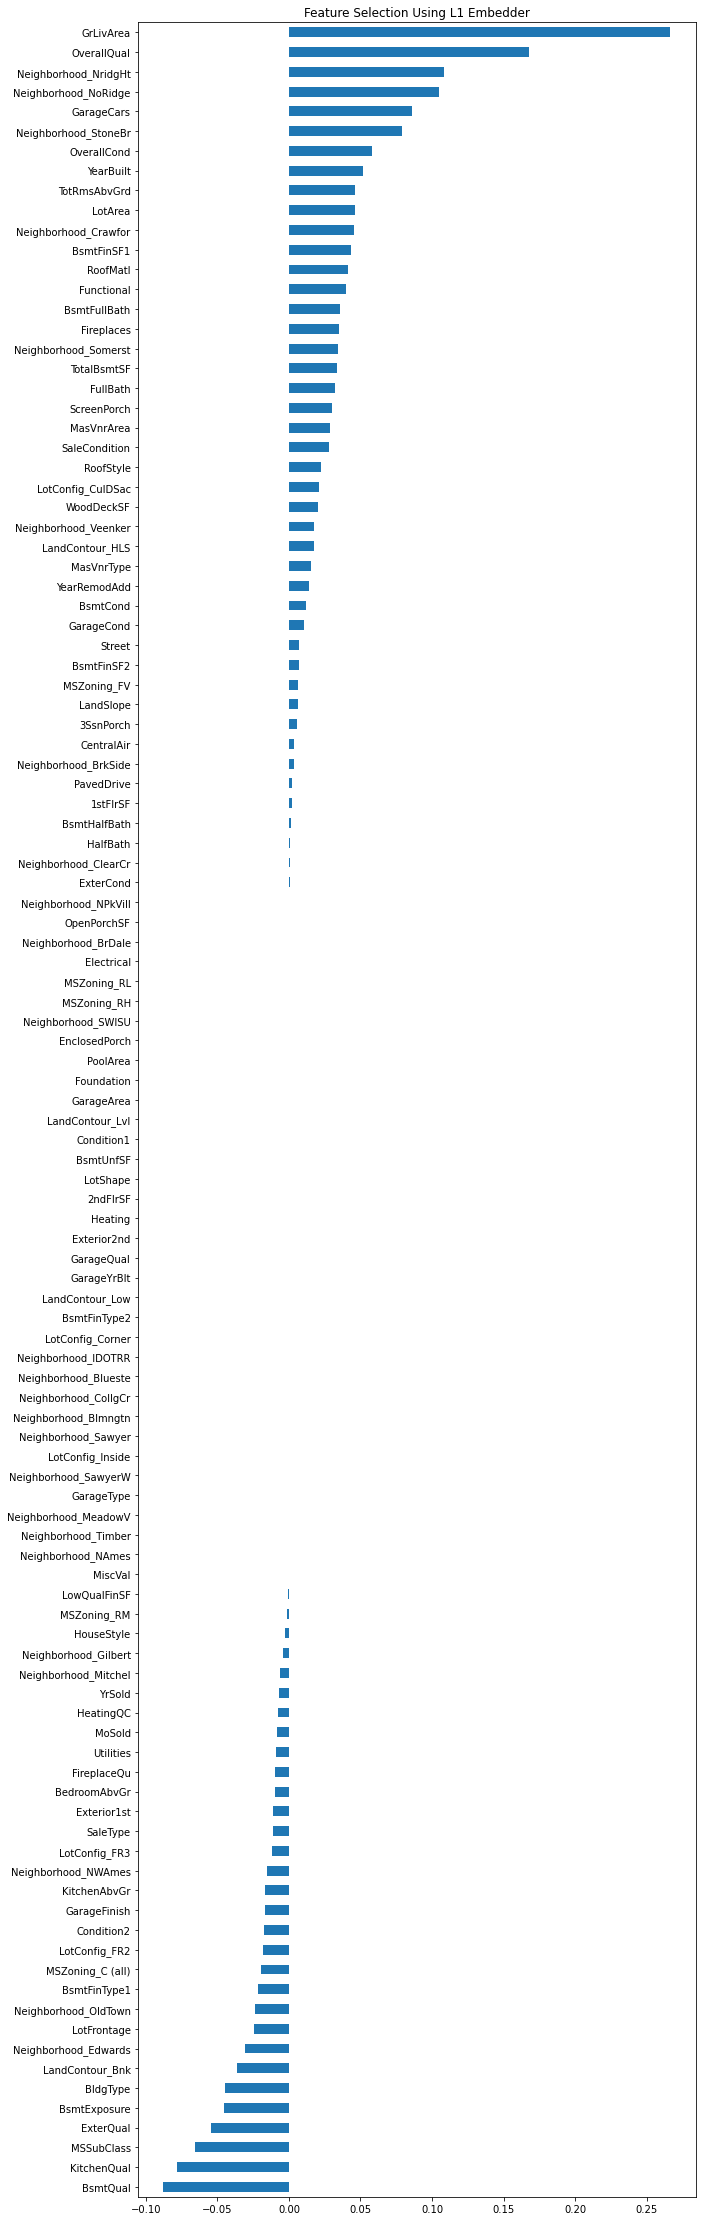

In [187]:
#print(lassova.coef_)

coef_col = pd.Series(lasso.coef_,index=X_without_target.columns)

#print(coef_col)
sorted_coef = coef_col.sort_values()
matplotlib.rcParams['figure.figsize']=(10.0,40.0)
sorted_coef.plot(kind="barh")

no_of_selected_features = sum(coef_col != 0)
no_of_rejected_features = sum(coef_col == 0)
total_features = no_of_selected_features + no_of_rejected_features
print("L1 selected only ",no_of_selected_features," features out of ",total_features," from the transformed dataset ")
plt.title("Feature Selection Using L1 Embedder")

Drop rejected features from dataset

In [188]:
rejected_features=[]
for label, value in zip(coef_col.index, coef_col.values):
  if value ==0:
    rejected_features.append(label)
rejected_features

['GarageYrBlt',
 '2ndFlrSF',
 'BsmtUnfSF',
 'PoolArea',
 'EnclosedPorch',
 'GarageArea',
 'MSZoning_RH',
 'MSZoning_RL',
 'LandContour_Low',
 'LandContour_Lvl',
 'LotConfig_Corner',
 'LotConfig_Inside',
 'Neighborhood_Blmngtn',
 'Neighborhood_Blueste',
 'Neighborhood_CollgCr',
 'Neighborhood_IDOTRR',
 'Neighborhood_MeadowV',
 'Neighborhood_NAmes',
 'Neighborhood_SWISU',
 'Neighborhood_Sawyer',
 'Neighborhood_SawyerW',
 'Neighborhood_Timber',
 'Foundation',
 'Electrical',
 'Condition1',
 'LotShape',
 'Heating',
 'Exterior2nd',
 'GarageQual',
 'GarageType',
 'BsmtFinType2']

In [189]:
df_standardized=pd.DataFrame(X_standardized, columns=X_without_target.columns)
X_selected = df_standardized.drop(rejected_features, axis=1)
X_selected

,LotArea,YearBuilt,MSSubClass,TotRmsAbvGrd,YearRemodAdd,BedroomAbvGr,LotFrontage,BsmtFinSF2,FullBath,Fireplaces,OverallQual,KitchenAbvGr,LowQualFinSF,WoodDeckSF,1stFlrSF,BsmtHalfBath,BsmtFullBath,GrLivArea,YrSold,OverallCond,MasVnrArea,GarageCars,BsmtFinSF1,ScreenPorch,3SsnPorch,MiscVal,HalfBath,MoSold,OpenPorchSF,TotalBsmtSF,MSZoning_C (all),MSZoning_FV,MSZoning_RM,LandContour_Bnk,LandContour_HLS,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_Mitchel,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Veenker,BsmtFinType1,BsmtCond,SaleCondition,Exterior1st,BsmtExposure,Condition2,HouseStyle,GarageFinish,Street,BldgType,GarageCond,SaleType,PavedDrive,RoofMatl,ExterCond,Functional,CentralAir,KitchenQual,BsmtQual,ExterQual,RoofStyle,HeatingQC,FireplaceQu,LandSlope,Utilities,MasVnrType
0,-0.207142,1.050994,0.073375,0.912210,0.878668,0.163779,-0.229372,-0.288653,0.789741,-0.951226,0.651479,-0.211454,-0.120242,-0.752176,-0.793434,-0.241061,1.107810,0.370333,0.138777,-0.517200,0.511418,0.311725,0.575425,-0.270208,-0.116339,-0.087688,1.227585,-1.599111,0.216503,-0.459303,-0.083045,-0.215859,-0.418955,-0.21236,-0.188311,-0.262324,-0.182380,-0.052414,-0.105263,-0.203395,-0.139832,-0.190252,-0.271163,-0.239176,-0.186352,-0.078757,-0.229416,-0.169981,-0.235958,-0.289638,-0.250182,-0.131991,-0.087129,-0.398741,0.286468,0.208502,0.743092,0.638078,-0.03174,1.026689,-0.227521,0.064238,-0.411691,0.191521,0.313867,0.289745,-0.125797,0.364207,0.255978,0.263813,-0.409369,-0.299527,-0.777976,-0.491516,-0.884658,1.115711,-0.225716,-0.02618,-1.236344
1,-0.091886,0.156734,-0.872563,-0.318683,-0.429577,0.163779,0.451936,-0.288653,0.789741,0.600495,-0.071836,-0.211454,-0.120242,1.626195,0.257140,3.948809,-0.819964,-0.482512,-0.614439,2.179628,-0.574410,0.311725,1.171992,-0.270208,-0.116339,-0.087688,-0.761621,-0.489110,-0.704483,0.466465,-0.083045,-0.215859,-0.418955,-0.21236,-0.188311,-0.262324,5.483049,-0.052414,-0.105263,-0.203395,-0.139832,-0.190252,-0.271163,-0.239176,-0.186352,-0.078757,-0.229416,-0.169981,-0.235958,-0.289638,-0.250182,-0.131991,11.477250,-1.492001,0.286468,0.208502,-0.508251,-1.109753,-0.03174,-0.543457,-0.227521,0.064238,-0.411691,0.191521,0.313867,0.289745,-0.125797,0.364207,0.255978,0.263813,0.795629,-0.299527,0.663451,-0.491516,-0.884658,1.115711,-0.225716,-0.02618,0.389838
2,0.073480,0.984752,0.073375,-0.318683,0.830215,0.163779,-0.093110,-0.288653,0.789741,0.600495,0.651479,-0.211454,-0.120242,-0.752176,-0.627826,-0.241061,1.107810,0.515013,0.138777,-0.517200,0.323060,0.311725,0.092907,-0.270208,-0.116339,-0.087688,1.227585,0.990891,-0.070361,-0.313369,-0.083045,-0.215859,-0.418955,-0.21236,-0.188311,-0.262324,-0.182380,-0.052414,-0.105263,-0.203395,-0.139832,-0.190252,-0.271163,-0.239176,-0.186352,-0.078757,-0.229416,-0.169981,-0.235958,-0.289638,-0.250182,-0.131991,-0.087129,-0.398741,0.286468,0.208502,0.743092,-0.235838,-0.03174,1.026689,-0.227521,0.064238,-0.411691,0.191521,0.313867,0.289745,-0.125797,0.364207,0.255978,0.263813,-0.409369,-0.299527,-0.777976,-0.491516,-0.884658,1.115711,-0.225716,-0.02618,-1.236344
3,-0.096897,-1.863632,0.309859,0.296763,-0.720298,0.163779,-0.456474,-0.288653,-1.026041,0.600495,0.651479,-0.211454,-0.120242,-0.752176,-0.521734,-0.241061,1.107810,0.383659,-1.367655,-0.517200,-0.574410,1.650307,-0.499274,-0.270208,-0.116339,-0.087688,-0.761621,-1.599111,-0.176048,-0.687324,-0.083045,-0.215859,-0.418955,-0.21236,-0.188311,-0.262324,-0.182380,-0.052414,-0.105263,-0.203395,-0.139832,5.256182,-0.271163,-0.239176,-0.186352,-0.078757,-0.229416,-0.169981,-0.235958,-0.289638,-0.250182,-0.131991,-0.087129,-1.492001,-2.711695,-3.426284,1.055928,0.638078,-0.03174,1.026689,1.007349,0.064238,-0.411691,0.191521,0.313867,0.289745,-0.125797,0.364207,0.255978,0.2638

# Deep Foward ANN

input shape layer=79->no of selected features
Adam optimizer used

In [190]:
model=Sequential()
model.add(Dense(128, input_shape = (X_selected.shape[1],), activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32))
model.compile(Adam(learning_rate=0.01), loss='mean_squared_error', metrics=['MSE'])

Split train set and test set

In [191]:
X_train, X_test, Y_train, Y_test = train_test_split(X_selected, y, test_size=0.3, random_state=40)

In [192]:
history = model.fit(X_train, Y_train, verbose = 1, epochs=100, validation_data=(X_test, Y_test))

Epoch 1/100
32/32 [==============================] - 1s 14ms/step - loss: 0.5617 - MSE: 0.5617 - val_loss: 0.1237 - val_MSE: 0.1237
Epoch 2/100
32/32 [==============================] - 0s 3ms/step - loss: 0.2070 - MSE: 0.2070 - val_loss: 0.1727 - val_MSE: 0.1727
Epoch 3/100
32/32 [==============================] - 0s 3ms/step - loss: 0.1096 - MSE: 0.1096 - val_loss: 0.1617 - val_MSE: 0.1617
Epoch 4/100
32/32 [==============================] - 0s 3ms/step - loss: 0.1220 - MSE: 0.1220 - val_loss: 0.1102 - val_MSE: 0.1102
Epoch 5/100
32/32 [==============================] - 0s 3ms/step - loss: 0.0703 - MSE: 0.0703 - val_loss: 0.1156 - val_MSE: 0.1156
Epoch 6/100
32/32 [==============================] - 0s 3ms/step - loss: 0.0574 - MSE: 0.0574 - val_loss: 0.1200 - val_MSE: 0.1200
Epoch 7/100
32/32 [==============================] - 0s 3ms/step - loss: 0.0441 - MSE: 0.0441 - val_loss: 0.1204 - val_MSE: 0.1204
Epoch 8/100
32/32 [==============================] - 0s 2ms/step - loss: 0.0503 - 

Testing using test set

In [193]:
predictions = model.predict(X_test)
predictions

array([[-0.00256172, -0.00263953, -0.00256255, ..., -0.00256288,
        -0.00250345, -0.00255701],
       [-0.13310254, -0.13320193, -0.133113  , ..., -0.13311529,
        -0.13306499, -0.13311666],
       [ 0.6069712 ,  0.6069373 ,  0.6069912 , ...,  0.60688525,
         0.60716784,  0.6069678 ],
       ...,
       [-0.523463  , -0.5235858 , -0.5235077 , ..., -0.52356434,
        -0.52353626, -0.52366245],
       [ 0.06055647,  0.06048909,  0.06056032, ...,  0.06056091,
         0.06062475,  0.06057033],
       [ 0.16027087,  0.16021997,  0.1602821 , ...,  0.16028416,
         0.16035497,  0.16029912]], dtype=float32)

Graph showing performance

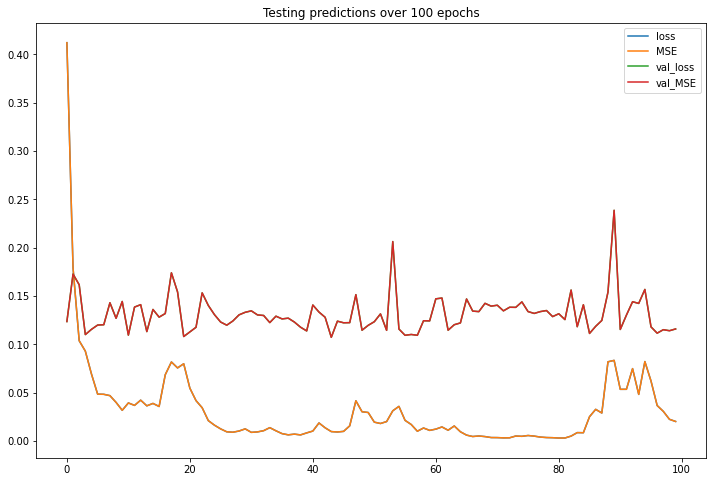

In [194]:
historydf=pd.DataFrame(history.history, index=history.epoch)
historydf.plot(title="Testing predictions over 100 epochs",figsize=(12,8))